In [1]:
import sys
import os
from datetime import datetime
import copy
import numpy as np
import pandas as pd
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint

sys.path.append(os.getcwd())

import trinity
from brownian import *

In [2]:
# We first generate the token price via GBM

s0 = [100,100,100] # *** To be modified ***
mu = [0.05,0.05,0.05] # *** To be modified ***
sig = [0.1,0.1,0.1] # *** To be modified ***
cv = [[0.01,0.005,0.005],[0.005,0.04,0.02],[0.005,0.02,0.16]] # *** To be modified ***
step = 252 # *** To be modified ***
extra = 1 # *** To be modified ***

Generator = Brownian(s0, mu, sig, cv, step + extra)
s = Generator.generate()

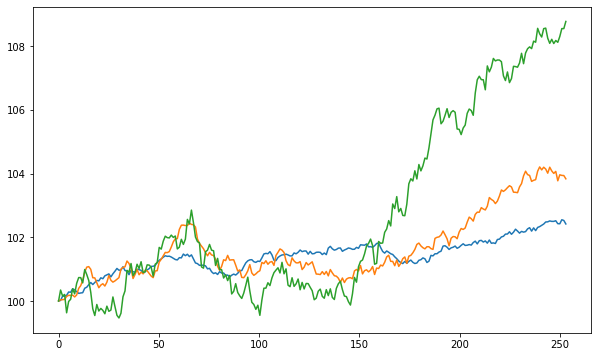

In [3]:
# Plot graph

x = np.linspace(0,step + extra, step + extra)
plt.figure(num = len(s0), figsize=(10, 6))
for i in range(len(s0)):
    plt.plot(x, s[i].flatten())
plt.show()

In [4]:
def run(s, print_ind = False):
    
    """
    Block begin initialization.
    """
    
    trinity.print_ind = print_ind
    f_ = np.vectorize(trinity.f, otypes=[float])
    arb_profit = 0
    
    # Create the Pool
    Trinity = trinity.pool()
    
    # Create the Users
    Peter = trinity.users("Peter") # Peter is the user
    Mary = trinity.users("Mary") # Mary is the arbitrageur
    Others = trinity.users("Others") # This is an external system (for book keeping of arbitrageur)
    
    """
    Block begin user inputs.
    Change all inputs, including tokens, parameters setup here
    """
    
    # Create all the tokens here
    ETH = trinity.tokens('ETH') # *** To be modified ***
    DAI = trinity.tokens('DAI') # *** To be modified ***
    CRO = trinity.tokens('CRO') # *** To be modified ***
    
    # Set the parameters for transaction counts (follow poisson(lambda)) and transaction amount (follow normal(0, phi^2))
    # Note that parameters must be in the order of "for i++ for j++", with array size equals to n * (n-1) / 2
    # For example: with 3 tokens ETH, DAI and CRO, the order needs to be ETH_DAI, ETH_CRO and DAI_CRO
    lambda_ = [1,1,1] # *** To be modified ***
    phi_ = [10000, 10000, 10000] # *** To be modified ***

    # Arbitrageur related parameters
    gas_cost_usd = 100 # *** To be modified ***
    margin = 1.2 # *** To be modified ***
    unwind_ind = True  # *** To be modified ***
    true_price_offset = 1 # *** To be modified ***

    # User wallet
    Peter.wallet = {"ETH": 200000, "DAI": 200000, "CRO": 200000} # *** To be modified ***
    Mary.wallet = {"ETH": 200000, "DAI": 200000, "CRO": 200000} # *** To be modified ***
    Others.wallet = {"ETH": 100000, "DAI": 100000, "CRO": 100000} # *** To be modified ***

    """
    Block begin initialization after user inputs.
    """
    
    Tokens = trinity.tokens.get_instances()
    m = len(Tokens)
        
    for i in range(m):
        Tokens[i].price = s[i,0]
        Tokens[i].true_price = s[i,true_price_offset]
        
    Users = trinity.users.get_instances()
    init_state = dict(Counter(Peter.wallet)+Counter(Mary.wallet)+Counter(Others.wallet))
    Mary_init = copy.deepcopy(Mary.wallet)

    # Initial Deposit
    Peter.deposit(Trinity, ETH, 100000) # *** To be modified ***
    Peter.deposit(Trinity, DAI, 100000) # *** To be modified ***
    Peter.deposit(Trinity, CRO, 100000) # *** To be modified ***
    
    """
    Block begin main loop.
    """
    
    for t in range(1,step):

        # Set the new price
        for i in range(m):
            Tokens[i].price = s[i,t]
            Tokens[i].true_price = s[i,t+true_price_offset]
            
            # Set the true price equal to system price at last time step
            if t == step-1:
                Tokens[i].true_price = s[i,t]

        counter = 0
        for ft in range(m):
            for tt in range(ft+1, m):
                count = np.random.poisson(lambda_[counter])
                for c in range(count):
                    from_token = Tokens[ft]
                    to_token = Tokens[tt]

                    # User Actions
                    amount = np.random.normal(0, phi_[counter])
                    if amount > 0:
                        Peter.swap(Trinity, from_token, to_token, amount/from_token.price)
                    else:
                        Peter.swap(Trinity, to_token, from_token, -amount/to_token.price)

                counter += 1

        # Arbitrager calculation
        r = np.array(list(map(lambda x: x.cov_ratio(), Tokens)))
        L = np.array(list(map(lambda x: x.liab(), Tokens)))
        fx = np.array(list(map(lambda x: x.price, Tokens)))
        fx_ = np.array(list(map(lambda x: x.true_price, Tokens)))

        constraint = LinearConstraint(L*fx, np.sum(L*fx*r), np.sum(L*fx*r))

        optimizer = minimize(
            lambda r_: np.dot(L*fx_,(f_(r_)-f_(r))-(r-r_)),
            x0=r,
            constraints=constraint)

        eqm = optimizer["x"]

        diff_pd = pd.DataFrame(data=L*fx*(eqm - r), columns = ["deltax"])
        diff_pd = diff_pd.sort_values(by=['deltax'], ascending=False)

        for i in range(m):
            r = np.array(list(map(lambda x: x.cov_ratio(), Tokens)))
            diff_pd = pd.DataFrame(data=L*fx*(eqm - r), columns = ["deltax"])
            diff_pd = diff_pd.sort_values(by=['deltax'], ascending=False)
            ft = diff_pd.index[0]
            tt = diff_pd.index[-1]
            slicer = [ft,tt]
            r_ = np.array(list(map(lambda x: x.cov_ratio(), Tokens)))    
            r_[ft] = eqm[ft]
            r_[tt] = r_[tt] - diff_pd.values[0][0]/(L[tt]*fx[tt])
            
            profit = -np.dot(L[slicer]*fx_[slicer],(f_(r_[slicer])-f_(r[slicer]))-(r[slicer]-r_[slicer]))
            
            # Only do arbitrage if condition is fulfilled
            # Note that the t == step - 1 is to remove any system surplus at the end for measuring true system equity
            
            proxy_haircut = diff_pd.values[0][0] * trinity.h
            arb_threshold = (gas_cost_usd + proxy_haircut) * margin
            
            if profit > arb_threshold: #or t == step-1:
                Mary.swap(Trinity, Tokens[ft], Tokens[tt], diff_pd.values[0][0]/fx[ft])
            
        if unwind_ind:
            # Unwind arbitrageur position
            for token in Tokens:
                arb_profit += (Mary.wallet[token.name] - Mary_init[token.name])*token.true_price
                Others.wallet[token.name] += Mary.wallet[token.name] - Mary_init[token.name]
                Mary.wallet[token.name] = Mary_init[token.name]
                
    System_Equity = reduce(lambda x, y: x + y, map(lambda x: (x.asset() - x.liab()) * x.true_price, Tokens))
    System_Haircut = reduce(lambda x, y: x + y, map(lambda x: x.hf_sys * x.true_price, Tokens))
    System_FX = System_Equity - System_Haircut

    """
    Block begin debug print.
    """
    
    if print_ind:
        # Leakage Test
        
        print("---------")
        for token in Tokens:
            user_cash = 0
            for user in Users:
                user_cash += user.wallet[token.name]
            token_end_balance = token.cash + user_cash
            leakage = init_state[token.name] - token_end_balance
            print('{0} leakage is {1}'.format(token.name, leakage))
            
        for user in Users:
            print("---------")
            print(user.name, "Wallet", user.wallet)
            print(user.name, "LP_Token", user.lp_token)

        for token in Tokens:
            print("---------")
            print(token.name, "Assets", token.asset())
            print(token.name, "Liabilities", token.liab())
            print(token.name, "Cov_Ratio", token.cov_ratio())
            print(token.name, "Quk_Ratio", token.quk_ratio())
            print(token.name, "LP_ROI", str(round((token.deposit/token.lp_tokens - 1)*100,4))+ "%")
            
        print("---------")
        print("Equity for System: " + str(System_Equity))
        print("Haircut for System: " + str(System_Haircut))
        print("FX Gain / Loss for system: " + str(System_FX))
        print("Arbitrageur Profit: " + str(arb_profit))
    
    return [System_Haircut, System_FX, arb_profit]

In [5]:
run(s, False)

[8141.455935964565, -8101.788509702011, 12618.695057352714]

In [6]:
max_sim = 1000
start=datetime.now()
sim_result = []

for sim in range(max_sim):
    sim_result.append(run(Generator.generate(), False))
    print('Running simulation {0} ...'.format(sim), end="\r")
    
print('{0} simulations completed. Total time used: {1}'.format(max_sim, datetime.now() - start), end="\r")

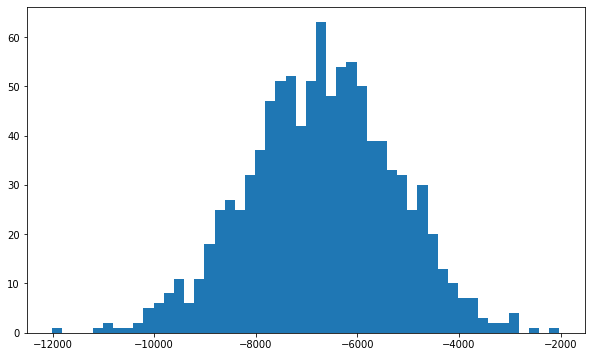

In [7]:
data = np.transpose(np.array(sim_result))

plt.figure(figsize=(10,6))
plt.hist(data[1], bins = 50)
plt.show()

In [8]:
# Simulation Result
VaR = np.quantile(data[1], 0.01)
mean_haircut = np.average(data[0])
mean_fx_risk = np.average(data[1])
mean_surplus = mean_haircut + mean_fx_risk
mean_arb_profit = np.average(data[2])

print("---------")
print("VaR for System: " + str(VaR))
print("---------")
print("Average System FX Risk: " + str(mean_fx_risk))
print("Average System Haircut: " + str(mean_haircut))
print("Average System Surplus: " + str(mean_surplus))
print("Average Arbitrageur Profit: " + str(mean_arb_profit))

---------
VaR for System: -10073.133675412068
---------
Average System FX Risk: -6711.037407189348
Average System Haircut: 7143.93500611274
Average System Surplus: 432.89759892339134
Average Arbitrageur Profit: 10235.116689631595
